# Machine Learning Notebook - Matt

In [53]:
%matplotlib inline
import HelperFunctions as hf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Load Data

In [2]:
#Load in the raw data
calendar_df = hf.load_calendar_data()
prices_df = hf.load_sell_price_data()
sales_df = hf.load_sales_train_validation_data()

## Clean Data

In [3]:
#Clean the raw data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1200, items=1000, dropNAPrices=True)

## Feature Engineering

In [4]:
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days

In [5]:
df = hf.rollingMeanWeekday(df, weeks = 3, shift = 1) #mean of previous 3 weeks (for that particular weekday)

/Users/mattwear/GroupWork/AML/HelperFunctions.py:230: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([data, d])


In [5]:
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before

In [6]:
df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [7]:
df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [8]:
df.isnull().sum()

d                    0
sold                 0
wday                 0
month                0
year                 0
snap_CA              0
snap_TX              0
snap_WI              0
sell_price           0
Cultural             0
National             0
Religious            0
Sporting             0
NoEvent              0
Christmas            0
weekend              0
midweek              0
monfri               0
FOODS_1              0
FOODS_2              0
FOODS_3              0
HOBBIES_1            0
HOBBIES_2            0
HOUSEHOLD_1          0
HOUSEHOLD_2          0
FOODS                0
HOBBIES              0
HOUSEHOLD            0
CA_1                 0
CA_2                 0
CA_3                 0
CA_4                 0
TX_1                 0
TX_2                 0
TX_3                 0
WI_1                 0
WI_2                 0
WI_3                 0
CA                   0
TX                   0
WI                   0
rolling_mean_7_1     0
rolling_mean_28_1    0
sold_lag_1 

In [9]:
df.shape

(782950, 46)

In [10]:
df.columns

Index(['d', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'Cultural', 'National', 'Religious', 'Sporting',
       'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri', 'FOODS_1',
       'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1',
       'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1', 'CA_2', 'CA_3',
       'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'CA', 'TX',
       'WI', 'rolling_mean_7_1', 'rolling_mean_28_1', 'sold_lag_1',
       'sold_lag_7', 'sold_lag_28'],
      dtype='object')

# Machine Learning

## Train/Test Split
We also isolate the target variables from the features

In [11]:
#Standardise features
cols_to_norm = ['d','wday','month','year','sell_price','rolling_mean_7_1','rolling_mean_28_1','sold_lag_1',
                'sold_lag_7','sold_lag_28']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [12]:
#Isolate features and target variable
y = df.sold.values
X_df = df.drop(['sold'], axis=1)
X = X_df.values

In [13]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(626360, 45)
(626360,)
(156590, 45)
(156590,)


## Linear Regression
The results of fitting a linear regression model on the data and analysing the feature's p-values raises some interesting findings. 
* Amongst the event related features only cultural and xmas are significant. As expected, Xmas is the most influential feature of them all.  
* The LR also confirms our findings in analysis that weekend/monfri/midweek are all significant features for predicting sales volume. 
* CA_4 and CA_3 is the only store that is an insignificant predictor. Perhaps higher population in this area?
* The mean of sold items in the week leading up is the second most influential feature.
* More expensive items sell in lower quantities

In [16]:
mod = sm.OLS(df['sold'], df[X_df.columns])
#mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   sold   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                 3.067e+04
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:01:35   Log-Likelihood:            -1.7991e+06
No. Observations:              771183   AIC:                         3.598e+06
Df Residuals:                  771146   BIC:                         3.599e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
d                    -1.7272      0.78

In [ ]:
###Train test split
###Normalise features
###More Data Analysis
###Feature Extraction - average of weekday - exponential averages - Eve Events
###Modelling
###Feature selection - Linear Regression/RandomForests/Lasso/Correlation plots

## Support Vector Regression
Due to the size of the dataset we can only really use LinearSVR here, since our dataset is too large to make nonlinear SVR's viable

In [21]:
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [42]:
svm_reg = LinearSVR(epsilon=0.2, C=0.1)
svm_reg.fit(X_train, y_train)

LinearSVR(C=0.1, dual=True, epsilon=0.2, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [43]:
preds_train = svm_reg.predict(X_train)
preds_test = svm_reg.predict(X_test)

In [44]:
print(mean_squared_error(y_train, preds_train))
print(mean_squared_error(y_test, preds_test))

6.957224753869866
6.410186853802001


In [45]:
#Coefficient of determination, R2
print(svm_reg.score(X_train, y_train))
print(svm_reg.score(X_test, y_test))

0.5876220564920145
0.6030520538245938


In [48]:
y_test

array([0, 0, 7, ..., 0, 0, 1])

In [49]:
test = pd.DataFrame({'true': y_test, 'preds':preds_test})

In [51]:
test.head(20)

,true,preds
0,0,0.210207
1,0,-0.090724
2,7,6.118969
3,13,7.811958
4,1,0.851409
5,4,0.972167
6,0,-0.070727
7,0,0.031361
8,0,-0.120097
9,2,0.556070


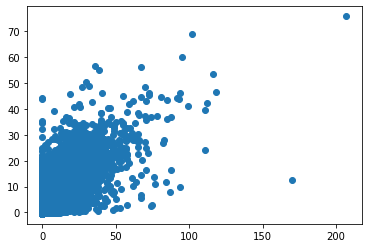

In [55]:
plt.scatter(test.true, test.preds)
plt.show()